# The Metropolitan Museum of Art Collection API
## Data Analysis, Modeling, and Forecasting

### The Metropolitan Museum of Art maintains over two million works of art and has assets valued at 3.7 billion dollars. Managing this large collection is a gargantuan task. This project seeks to understand the data behind The Met's collection and create a model for future growth.

### Business Understanding 
The Metropolitan Museum of Art has made available to the public an API (application programming interface) that contains almost 500,000 datapoints about their collection. This project uses their downloadable version available at https://github.com/metmuseum/openaccess. This project modifies some aspects of the dataset as detailed below. The data is made available via The Metropolitan Museum of Art's CC0 policy.

In 2019 alone, the Met's net assets increased by $63.1 million. With investments of this magnitude, the Met must ensure that is is growing at a proportional rate with that of the past. Their dataset includes information about both the characteristics of the pieces acquired, and the date when the museum acquired the pieces. I will be using ARIMA to model the time series of their acquisitions and predict and forecast future acquisitions in regard to previous acquisitions. 

### Data Understanding: 

The dataset is made available as a .csv file with 477,804 entries. This data is extremely well-suited for analysis as it is extremely large and dense with information about The Met's own collection. I will primarily focus on the columns:

"AccessionYear" The year in which the museum acquired the piece

"Classification" The type of piece detailed

"Object Begin Date" The time in which the piece was begun

"Object End Date" The time in which the piece was finished

I will engineer an additional column: "Object Time" which is the estimated time it took to create a particular work of art. The dataset has over 400,000 entries, but is still limited as The Met's collection exceeds 2 Million pieces of art work. Similar approaches may easily be used as the dataset grows to include more pieces. 

### Import Relevant Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_squared_error

### Initial Data Overview

In [26]:
data = pd.read_csv("MetObjects.csv")
data.head()

C:\Users\12676\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (5,7,10,11,12,13,14,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,...,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
0,1979.486.1,False,False,False,1,NaN,The American Wing,1979,Coin,One-dollar Liberty Head Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/1,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
1,1980.264.5,False,False,False,2,NaN,The American Wing,1980,Coin,Ten-dollar Liberty Head Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/2,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
2,67.265.9,False,False,False,3,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/3,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
3,67.265.10,False,False,False,4,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/4,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
4,67.265.11,False,False,False,5,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/5,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN


We can see that each work of art is listed as a row with 54 columns of attributes. Let's take a closer look at all of those attributes.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477804 entries, 0 to 477803
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Object Number            477804 non-null  object 
 1   Is Highlight             477804 non-null  bool   
 2   Is Timeline Work         477804 non-null  bool   
 3   Is Public Domain         477804 non-null  bool   
 4   Object ID                477804 non-null  int64  
 5   Gallery Number           51776 non-null   object 
 6   Department               477804 non-null  object 
 7   AccessionYear            474248 non-null  object 
 8   Object Name              476113 non-null  object 
 9   Title                    448619 non-null  object 
 10  Culture                  207379 non-null  object 
 11  Period                   90956 non-null   object 
 12  Dynasty                  23233 non-null   object 
 13  Reign                    11226 non-null   object 
 14  Port

There are clearly some attributes which are not present for every object in the collection. However, the attributes "AccessionYear", "Object Begin Date", "Object End Date", and "Classification" all have over 399,000 values. It makes sense to focus on these attributes for our analysis, as they are robust and almost every piece has values for these attributes. 

Let's take a closer look at the "Classification" attribute

In [11]:
a = data["Classification"]
a.value_counts()[:30]

Prints                                  80981
Prints|Ephemera                         28388
Photographs                             27091
Drawings                                22717
Vases                                   21315
Books                                   14764
Ceramics                                11059
Textiles-Woven                          11000
Photographs|Ephemera                    10018
Paintings                                8624
Negatives                                6133
Glass                                    6133
Prints|Ornament & Architecture           5171
Drawings|Ornament & Architecture         4974
Textiles-Laces                           4957
Ceramics-Porcelain                       4373
Textiles-Embroidered                     4086
Metalwork-Silver                         3976
Books|Prints|Ornament & Architecture     3752
Ceramics-Pottery                         3664
Sculpture                                3617
Textiles-Printed                  

This is a list of classifications ranked most numerous to least. We can see that this dataset is largely prints, with the combined classifications of "Prints" and "Prints | Ephemera" totalling to over 100,000 entries. Other types of work are also represented, although as we move down the list their classification becomes much more specific. All of these categories are good prospects to model acquisition time. 

### Data Preparation

Let's look at the column "AccessionYear" which is the year in which The Met acquired a piece. 

In [14]:
data["AccessionYear"].value_counts()

1963.0        34280
2011.0        17520
1917.0        12194
2009.0         9382
1936.0         9015
              ...  
2008              1
1893              1
1953-05-28        1
1915              1
2022.0            1
Name: AccessionYear, Length: 280, dtype: int64

We can see that the values have non-uniform formatting. Let's clean them up by limiting the values to their first 4 numbers and dropping any values that are not included. 

In [28]:
data = data.loc[data["AccessionYear"]!= "nan"]
data["AccessionYear"] = data["AccessionYear"].dropna(axis=0)
data["AccessionYear"] = data["AccessionYear"].astype("str")
data["AccessionYear"] = [year[:4] for year in data["AccessionYear"]] 
data["AccessionYear"] = data["AccessionYear"].astype("int")
data["AccessionYear"].value_counts()

1963    40339
2011    18618
1917    12403
1994    10594
2009     9386
        ...  
1877       10
2022        8
1872        4
1878        1
1870        1
Name: AccessionYear, Length: 153, dtype: int64

Great! Now the years are all integers in uniform format. Let's also feature engineer a column "Object Time" which is the amount of time each object took to create. 

In [36]:
data["Object Time"] = data["Object End Date"] - data["Object Begin Date"]

### Modeling

Let's begin by modeling The Met's acquisition of paintings since the year 2000. The subset of paintings makes a good choice for our initial model as the subset is rather small and memory-sensitive while still containing over 8,000 entries. We will create a time series where "AccessionYear" is the index and the total amount of paintings acquired each year is modeled. 

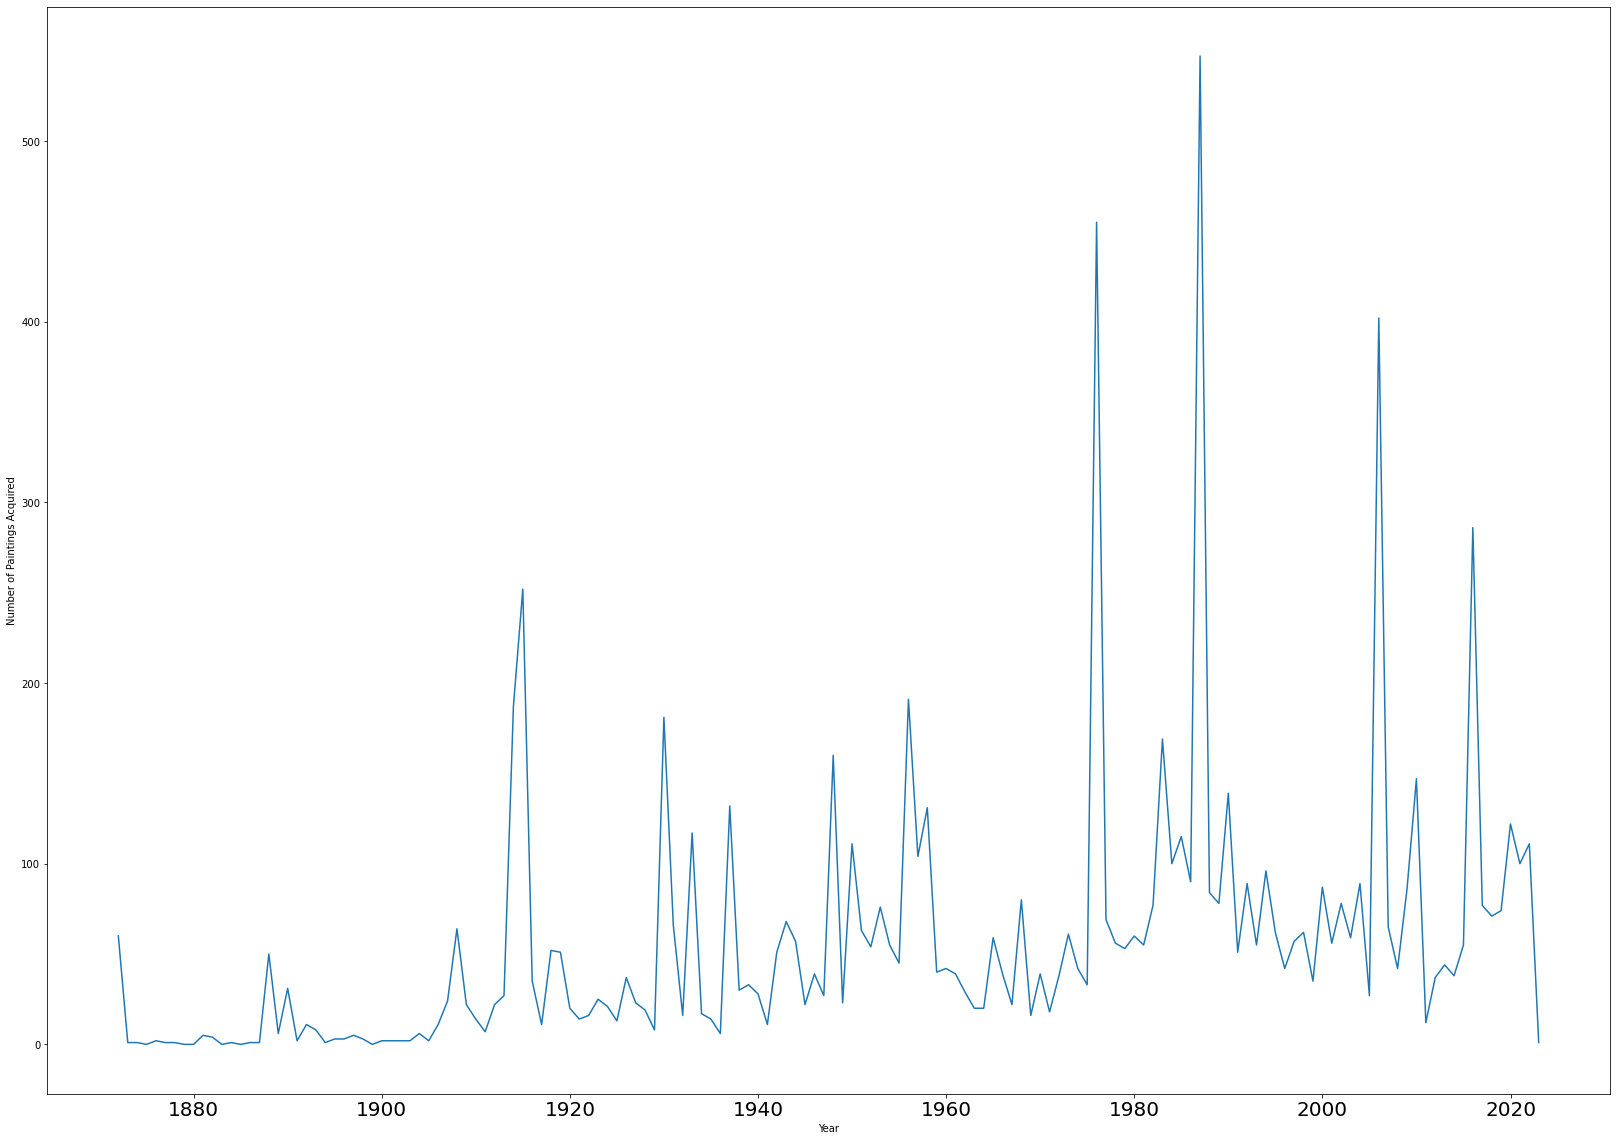

In [59]:
paintings_no_datetime = data[data["Classification"] == "Paintings"]
paintings = paintings_no_datetime.set_index(pd.to_datetime(paintings_no_datetime["AccessionYear"], format='%Y'))
paintings= paintings.drop(columns="AccessionYear")
paintings

## We will add the column "count" to our subset.
## This column gives each entry the value of 1, so that when summing by year each artwork is taken into account.
paintings["count"] = 1
pcounts = paintings.filter(["AccessionYear","count"], axis=1)
pcounts = pcounts.resample('Y').sum()
plt.figure(figsize=(28,20))
plt.plot(pcounts)
plt.xlabel("Year")
plt.xticks(fontsize=20)
plt.ylabel("Number of Paintings Acquired");

This is a visualization of the time series for the number of paintings acquired by year. We can see spikes right before 1920, 1980, 1990, and several spikes in the 2000s. We can see that it is obviously not stationary in its current form. 

### Baseline Model

For our baseline model, we will use a nieve shift of 1 degree and evaluate the Mean Squared Error for the model. 

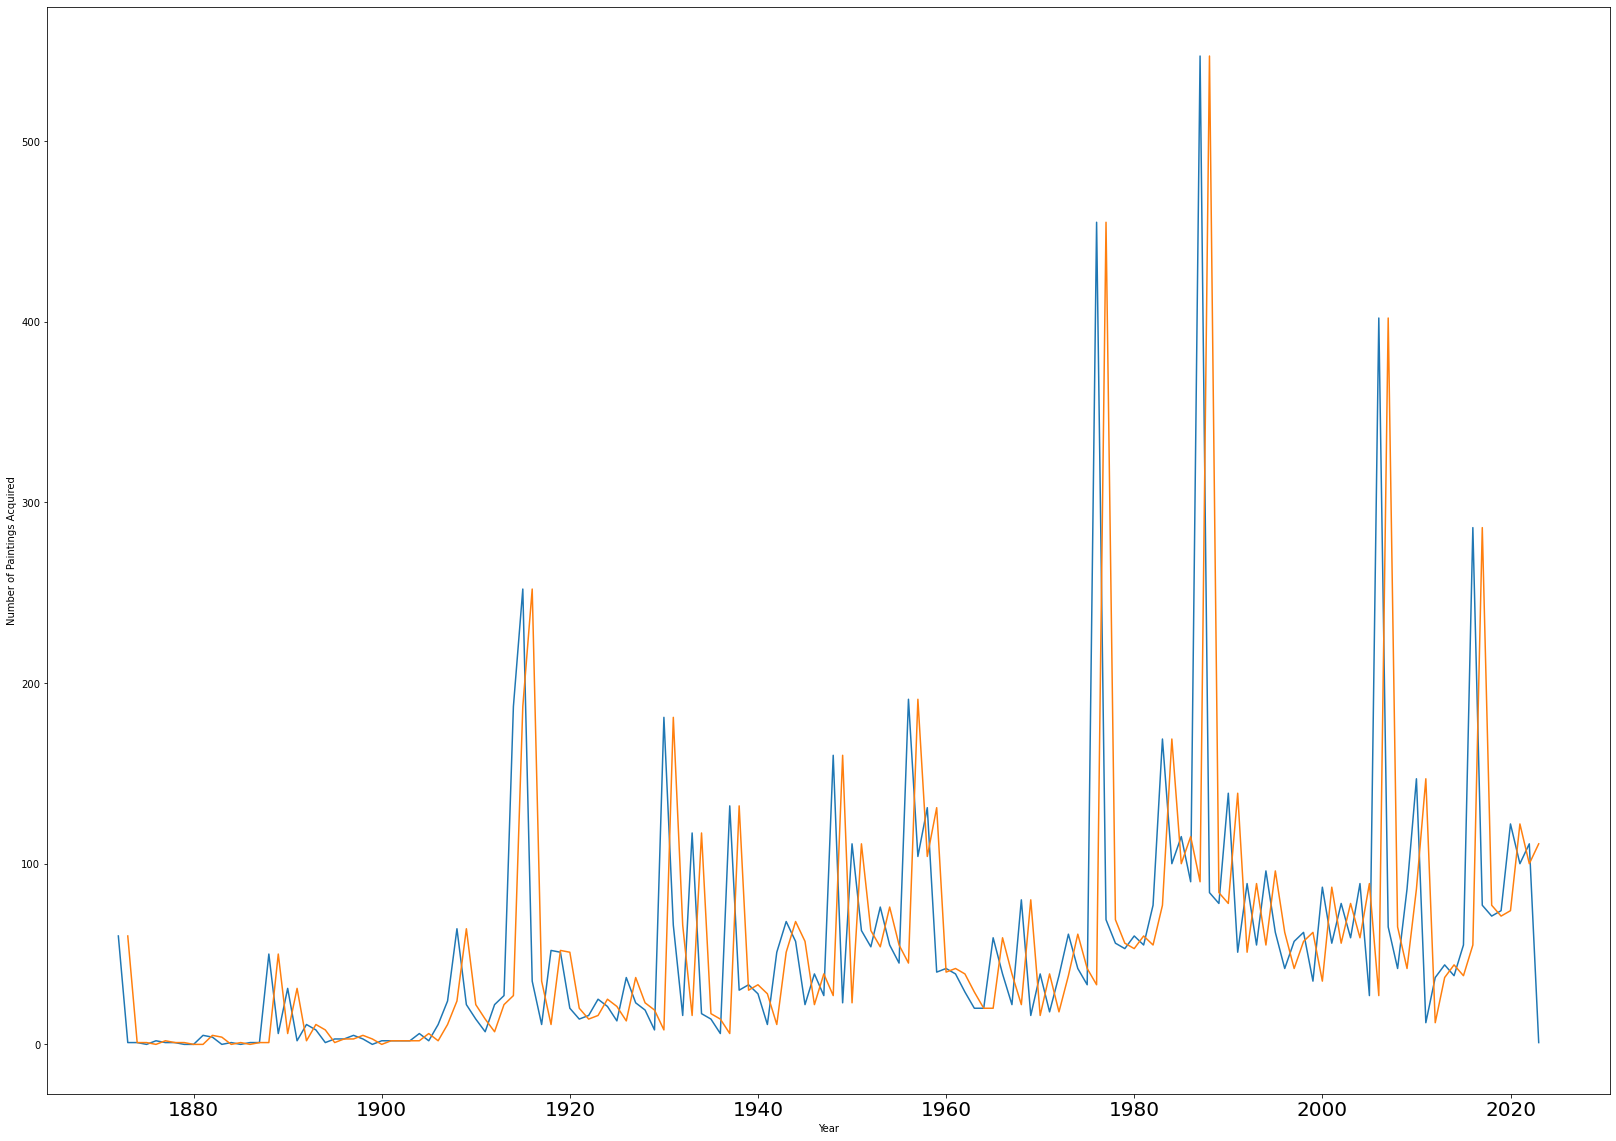

In [80]:
naivepaintings = pcounts.shift(1)
np.sqrt(mean_squared_error(pcounts[1:], naivepaintings.dropna()))
plt.figure(figsize=(28,20))
plt.plot(pcounts)
plt.plot(naivepaintings)
plt.xlabel("Year")
plt.xticks(fontsize=20)
plt.ylabel("Number of Paintings Acquired");

In [82]:
np.sqrt(mean_squared_error(pcounts[1:], naivepaintings.dropna()))

98.76867750268372

We now have a metric to beat for our model. Our model must beat the baseline score of MSE:98.769 to be an improvement.

### Stationarity

We will now difference the data for stationarity. 

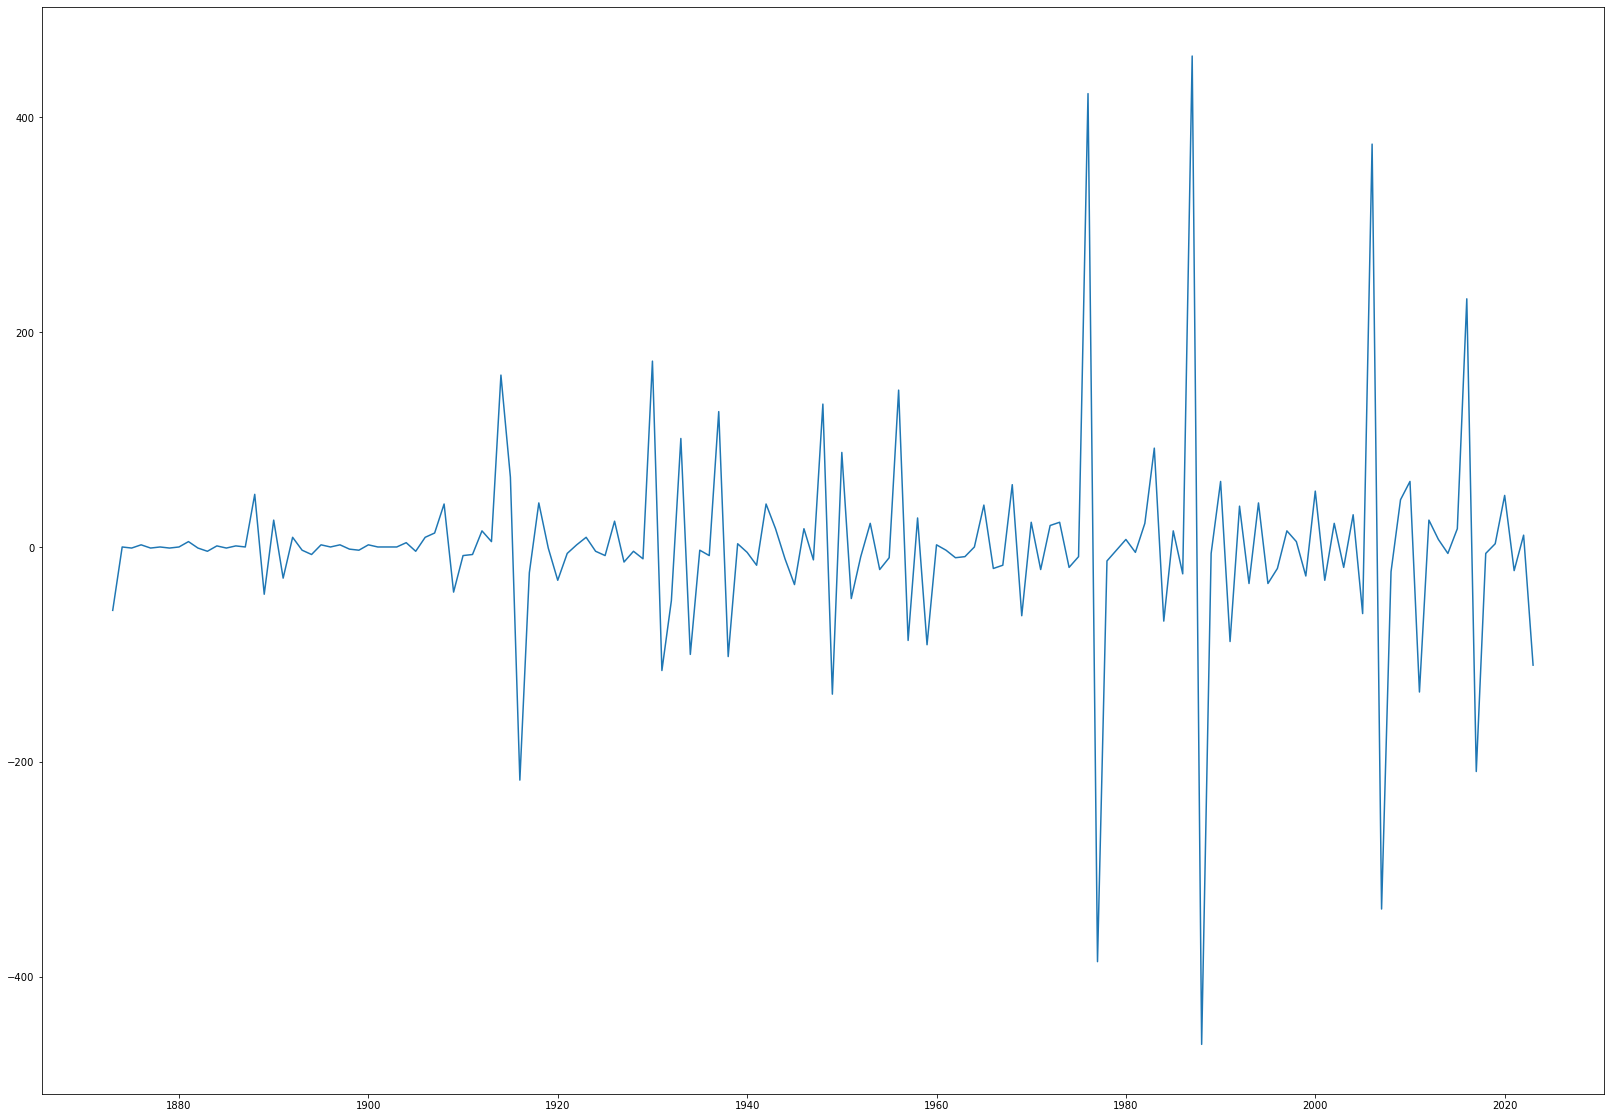

In [76]:
pcounts_diff = pcounts.diff().dropna()
plt.figure(figsize=(28,20))
plt.plot(pcounts_diff);

In [77]:
from statsmodels.tsa.stattools import adfuller
#A time series Differencing
result = adfuller(pcounts_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
print('Reject the null hypothesis. Data is Stationary')

ADF Statistic: -7.454894
p-value: 0.000000
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578
Reject the null hypothesis. Data is Stationary


After differencing, the AD Fuller test tells us that the data is stationary. We now know that we can construct an ARIMA model based on the series. 

### Train-Test Split

Let us make our training set on the years from the start to 2000, and the test set on the years 2000-2022. 

In [78]:
cutoff = "2000-12-31"
ptrain = pcounts[:cutoff]
ptest = pcounts[cutoff:]

In [ ]:
ar_1 = ARIMA(ptrain, order=(3),1,1).fit()
y_hat_p = parima.predict(btyp="levels")

### PACF and ACF to determine ARIMA degrees
Below are generated PACF and ACF curves to guide us in our ARIMA modeling process.

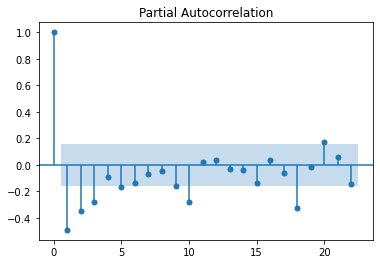

In [84]:
## This will determine the optimal AR value for our model
plot_pacf(pcounts.diff().dropna());

## We can test a good AR value of 3

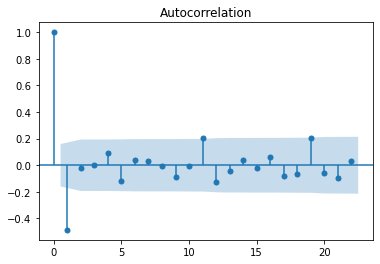

In [86]:
## This will determine the optimal MA value for our model
plot_acf(pcounts.diff().dropna());

## We can test a good MA value of 1

### ARIMA Modeling

In [88]:
ar_1 = ARIMA(ptrain, order=(3,1,1)).fit()
y_hat_p = ar_1.predict(btyp="levels")

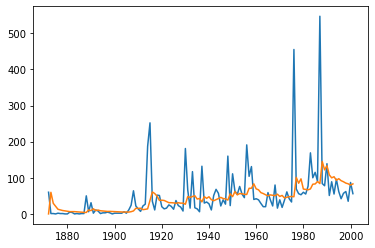

In [89]:
fig, ax = plt.subplots()
ax.plot(ptrain)
ax.plot(y_hat_p)

In [90]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                  130
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -729.659
Date:                Mon, 18 Apr 2022   AIC                           1469.318
Time:                        00:15:46   BIC                           1483.617
Sample:                    12-31-1871   HQIC                          1475.128
                         - 12-31-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0700      0.114      0.612      0.541      -0.154       0.294
ar.L2          0.0319      0.174      0.184      0.854      -0.309       0.373
ar.L3          0.0644      0.196      0.329      0.742      -0.319       0.448
ma.L1         -0.9373      0.057    -16.352      0.000      -1.050      -0.825
sigma2      4725.3731    215.534     21.924      0.000    4302.934    5147.812
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3209.62
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               4.96   Skew:                             4.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The following summary of our ARIMA process shows that our model has an AIC of 1469.32 We will now check our model on our testing set. 

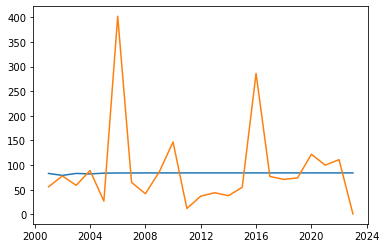

In [92]:
y_hat_test_p = ar_1.predict(start=ptest.index[0], end=ptest.index[-1],typ='levels')


fig, ax = plt.subplots()
ax.plot(y_hat_test_p)
ax.plot(ptest);

In [93]:
np.sqrt(mean_squared_error(ptest, y_hat_test_p))

87.0246897054411

Our MSE for our model test was 87.02, a noticable improvement from the 98.77 of our baseline model. We will now use our model to forecast a good plan for the next 10 years of paintings acquisitions. 

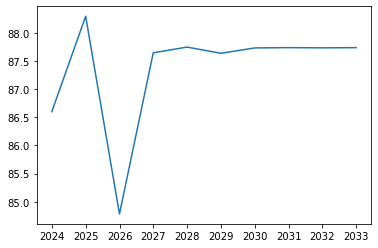

In [97]:
ar_2 = ARIMA(pcounts, order=(3,1,1)).fit()
y_hat_p = ar_2.predict(btyp="levels")
forecast = ar_2.forecast(steps=10)
fig, ax = plt.subplots()
ax.plot(forecast);

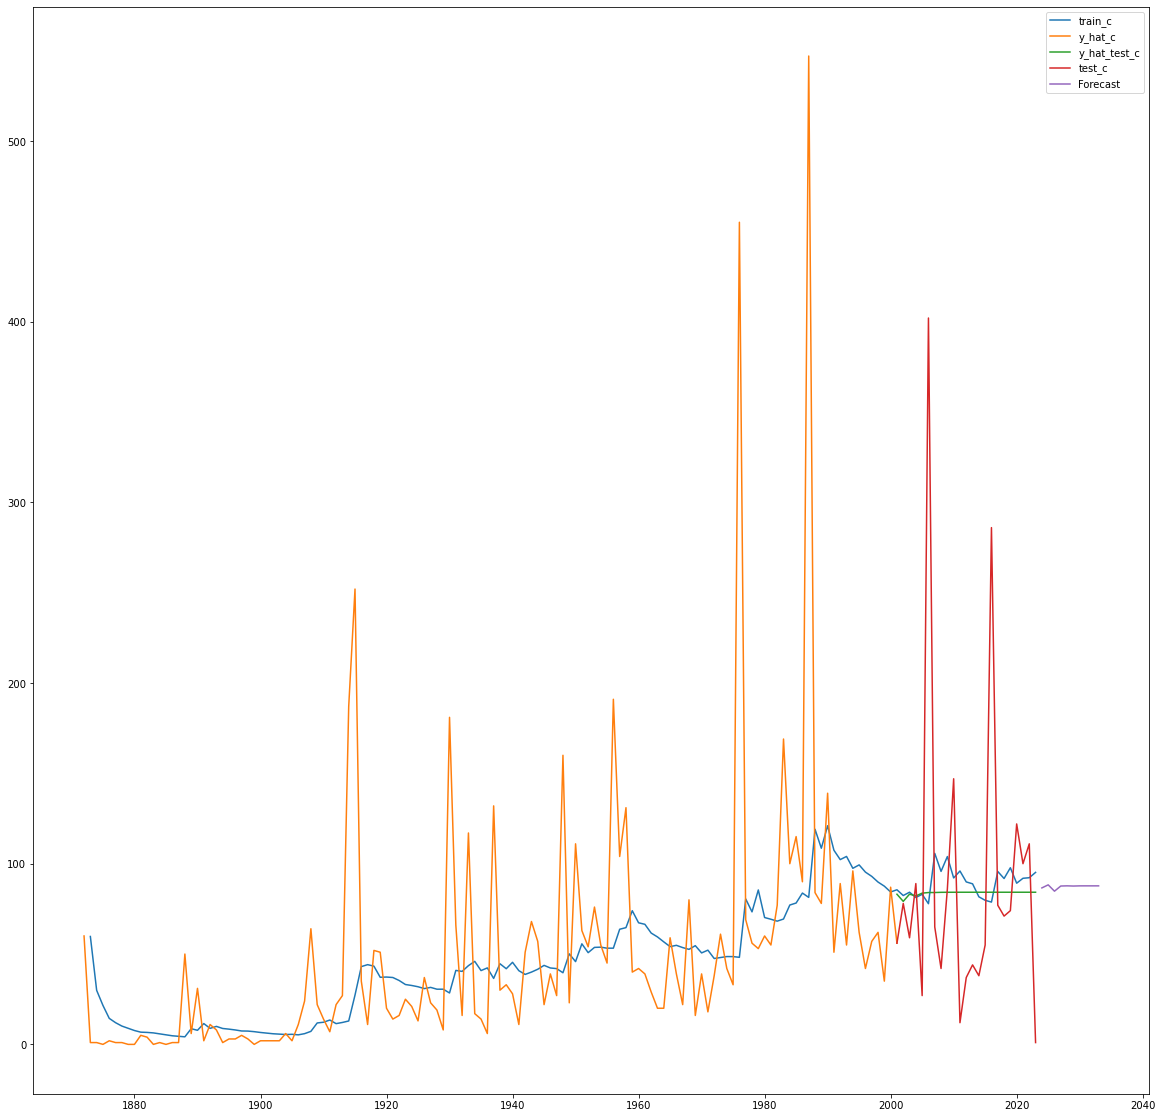

In [98]:
fig,ax = plt.subplots(figsize=(20,20))
ax.plot(y_hat_p[1:])
ax.plot(ptrain)
ax.plot(y_hat_test_p)
ax.plot(ptest)
ax.plot(forecast)
ax.legend(["train_c","y_hat_c","y_hat_test_c","test_c","Forecast"])